# Plot the data

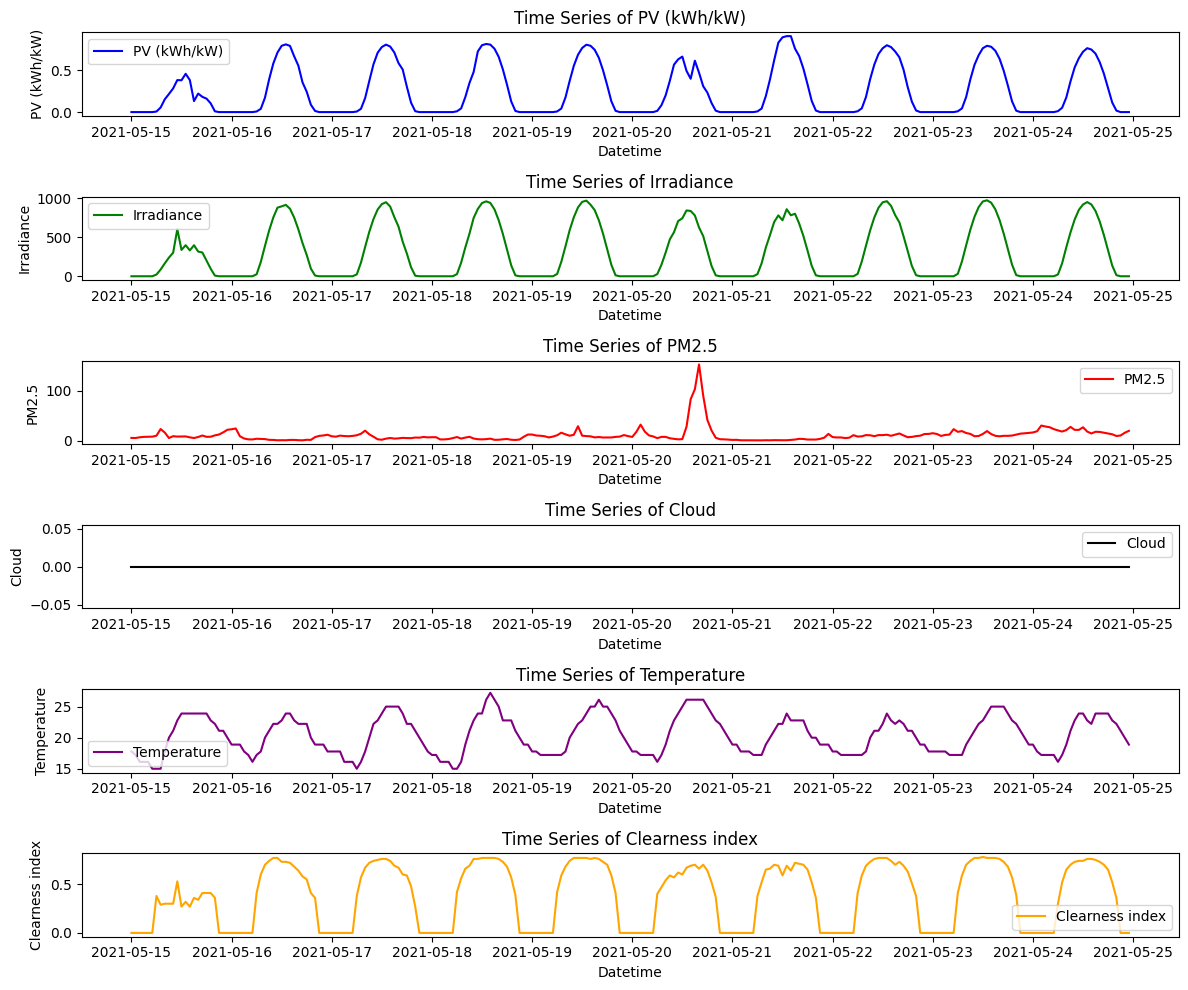

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np

# Change the PV file here
file_name = 'QWERTY.csv'  # Replace with your file name
pv = 'PV (kWh/kW)'
irr = 'Irradiance'
pm25 = 'PM2.5'
cloud = 'Cloud'
temp = 'Temperature'
KT = 'Clearness index'
# Define your start and end dates for the regression analysis
start_date = '2021-05-17'
end_date = '2021-05-24'    # Until end_date - 1

# Load the dataset and drop rows with missing values
df = pd.read_csv(file_name).dropna(axis=0)

# Convert 'Datetime' column to datetime type and set it as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Plotting all time series in one figure
plt.figure(figsize=(12, 10))

# Helper function to create a subplot for a variable
def plot_time_series(index, series, label, color):
    plt.subplot(6, 1, index)
    plt.plot(series, label=label, color=color)  # Plot the series directly
    plt.xlabel("Datetime")
    plt.ylabel(label)
    plt.title(f"Time Series of {label}")
    plt.legend()

# Plot each time series
plot_time_series(1, df[pv], pv, "blue")
plot_time_series(2, df[irr], irr, "green")
plot_time_series(3, df[pm25], pm25, "red")
plot_time_series(4, df[cloud], cloud, "black")
plot_time_series(5, df[temp], temp, "purple")
plot_time_series(6, df[KT], KT, "orange")  # Plot KT series

plt.tight_layout()
plt.show()



# Linear Regression - Cross Validation

In [282]:
# Filter the dataframe for the specified date range
df = df[(df.index >= start_date) & (df.index <= end_date)]

# Drop rows where the 'PV' column has zero values
df = df[df[pv] != 0]

# Separate the target variable and features, excluding specified columns
X = df.drop(columns=[pv, cloud, irr])
y = df[pv]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize K-Fold cross-validation, n_split = 7 beacause the data set has 7 days in totals
kfold = KFold(n_splits=7, shuffle=True, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Perform cross-validation and calculate R-squared scores
cv_scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='r2')
print(f'Cross-validation R-squared scores: {cv_scores}')
print(f'Average R-squared: {cv_scores.mean()}')

# Train the model on the entire dataset
model.fit(X_scaled, y)

# Extracting and displaying the model's coefficients and intercept
weights = pd.DataFrame({"Feature": X.columns, "Weight": model.coef_})
print("Intercept:", model.intercept_)
print(weights)

Cross-validation R-squared scores: [0.7801811  0.60468062 0.53588718 0.52480409 0.67964378 0.77958195
 0.82744185]
Average R-squared: 0.6760315104877519
Intercept: 0.42874095238095233
           Feature    Weight
0            PM2.5 -0.048929
1      Temperature  0.114860
2  Clearness index  0.175342


# PV Reduction

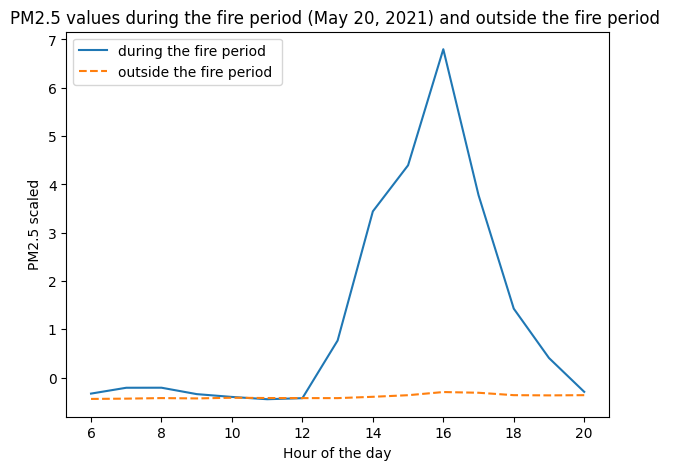

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [283]:
# First, get the dates from the original DataFrame that correspond to the scaled features
dates = df.index

# Now create a DataFrame from X_scaled using these dates as the index
X_scaled_df = pd.DataFrame(X_scaled, index=dates, columns=X.columns)

# Now you can use .loc to select the rows for the date 2021-05-20
may_20_data = X_scaled_df.loc['2021-05-20']

# Plot PM2.5 the date 2021-05-20 and 2021-05-21
plt.figure(figsize=(7, 5))
plt.plot(np.arange(6,21,1),may_20_data['PM2.5'].values, label='during the fire period')
plt.plot(np.arange(6,21,1),may_21_data['PM2.5'].values, label='outside the fire period ', linestyle='--')

plt.title('PM2.5 values during the fire period (May 20, 2021) and outside the fire period ')
plt.xlabel('Hour of the day')
plt.ylabel('PM2.5 scaled')
plt.legend()
plt.show()

# Replace 'PM2.5' values on May 20, 2021, with the average from the days no fire
pm25_replacement_value = X_scaled_df[X_scaled_df.index != '2021-05-20']['PM2.5'].mean()
may_20_data['PM2.5'] = pm25_replacement_value
# Calculate the hourly mean of 'PM2.5' values for all days except May 20, 2021
'''df_without_may_20 = X_scaled_df[X_scaled_df.index.date != pd.Timestamp('2021-05-20').date()]'''
# Calculate the hourly mean of 'PM2.5' values for all data except for May 20, 2021
'''pm25_replacement_value = df_without_may_20['PM2.5'].groupby(df_without_may_20.index.hour).mean()'''
# Now, for each hour in may_20_data, replace 'PM2.5' with the corresponding hourly mean value
'''for hour in may_20_data.index.hour:
    may_20_data.loc[may_20_data.index.hour == hour, pm25] = pm25_replacement_value[hour]'''

# Make predictions for May 20, 2021
predicted_PV_may_20 = lin.predict(may_20_data)

# Convert the predictions to a Pandas Series
predicted_PV_may_20 = pd.Series(predicted_PV_may_20, index=actual_PV_may_20.index)

# Extract actual y values for May 20, 2021
actual_PV_may_20 = df.loc['2021-05-20', pv]

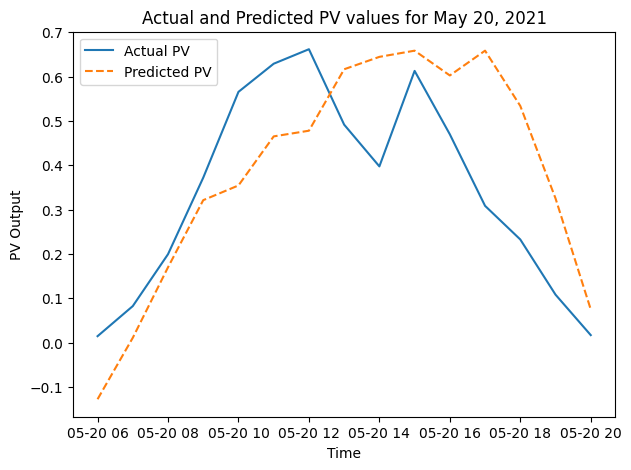

In [272]:
# Plotting actual values
plt.figure(figsize=(7, 5))
plt.plot(actual_PV_may_20, label='Actual PV')

# Assuming predicted_y_may_20 is a NumPy array with the predicted values for May 20, 2021
plt.plot(predicted_PV_may_20, label='Predicted PV', linestyle='--')

plt.title('Actual and Predicted PV values for May 20, 2021')
plt.xlabel('Time')
plt.ylabel('PV Output')
plt.legend()
plt.show()

In [273]:
#Calculate the reduction of PV production on May 20, 2021
PV_reduction = (predicted_PV_may_20.sum() - actual_PV_may_20.sum())*100/ predicted_PV_may_20.sum()
print("The reduction of PV production due to the fire is {:.2f}%".format(PV_reduction))

The reduction of PV production due to the fire is 10.78%


In [265]:
may_20_data

,PM2.5,Temperature,Clearness index
Datetime,,,
2021-05-20 06:00:00,3.581791e-17,-2.004049,-1.917297
2021-05-20 07:00:00,3.581791e-17,-1.622844,-1.368325
2021-05-20 08:00:00,3.581791e-17,-1.051037,-0.819352
2021-05-20 09:00:00,3.581791e-17,-0.288627,-0.427228
2021-05-20 10:00:00,3.581791e-17,0.283181,-0.584077
2021-05-20 11:00:00,3.581791e-17,0.664386,-0.191954
2021-05-20 12:00:00,3.581791e-17,1.045591,-0.348803
2021-05-20 13:00:00,3.581791e-17,1.426796,0.200170
2021-05-20 14:00:00,3.581791e-17,1.426796,0.357019
